In [19]:
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional
import tqdm
# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
# MONAI Libraries
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from monai.losses import MaskedLoss

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval 
from torch.nn.functional import mse_loss
from monai.losses.ssim_loss import SSIMLoss
import torch
import tqdm
from torch.cuda.amp import autocast

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')
import wandb
wandb.init(project='3D_ddpm',name='test_inpaint_brats')
# os.environ["CUDA_VISIBLE_DEVICES"] = "2,4"

In [20]:
# Initialize Configuration
config = {
    'batch_size': 1,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 1,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")




imgpath = {}
# '/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv'
#'/acmenas/hakrami/patched-Diffusion-Models-UAD/Data/splits/IXI_train_fold0.csv',
#csvpath_trains = ['/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv', '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/BioBank_train.csv']
csvpath_trains=['./Data/splits/combined_4datasets.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = './Data/splits/IXI_test.csv'
csvpath_test = './Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)


var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)


for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] = ''
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase  + var_csv[state]['seg_path']

  
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)


val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)
test_loader = DataLoader(data_test, batch_size=1,shuffle=False,num_workers=8)

device = torch.device("cuda")


model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 64],
    attention_levels=[False, False,True],
    num_head_channels=[0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/model_large_epoch999.pt'
model.load_state_dict(torch.load(model_filename))
model.eval()

Using 2 GPUs!


DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
       

In [21]:
def denoise(noised_img,sample_time,scheduler,inferer,model):
    with torch.no_grad():
        with autocast(enabled=True):
            for t in range(sample_time - 1, -1, -1):
                batch_size = noised_img.size(0)  # Get the batch size
                t_batch=torch.Tensor((t,)).to(noised_img.device)
                t_batch = t_batch.unsqueeze(0).expand(batch_size, -1)  # Expand tensor `t` to have the desired batch size
                t_batch = t_batch.to(noised_img.device)[:,0] 
                model_output = model(noised_img, timesteps=t_batch)
                noised_img, _ = scheduler.step(model_output, t, noised_img)
            return noised_img

    


def inpaint_image(image_array, mask, mean_denoised, model, scheduler, device):
    # Convert inputs to tensors and move to the specified device
    
    mask = mask.to(device)
    val_image_masked = image_array.to(device)
    val_image_inpainted = torch.randn_like(val_image_masked).to(device)
    timesteps = torch.Tensor((999,)).to(device).long()
    scheduler.set_timesteps(num_inference_steps=999)
    progress_bar = tqdm.tqdm(scheduler.timesteps)

    num_resample_steps = 4
    with torch.no_grad():
        with autocast(enabled=True):
            for t in progress_bar:
                for u in range(num_resample_steps):
                # get the known portion at t-1
                    if t > 0:
                        noise =  torch.randn_like(val_image_masked).to(device)
                        timesteps_prev = torch.Tensor((t - 1,)).to(device).long()
                        val_image_inpainted_prev_known = scheduler.add_noise(
                            original_samples=val_image_masked, noise=noise, timesteps=timesteps_prev
                        )
                    else:
                        val_image_inpainted_prev_known = val_image_masked
                
                # perform a denoising step to get the unknown portion at t-1
                    if t > 0:
                        timesteps = torch.Tensor((t,)).to(device).long()
                        model_output = model(val_image_inpainted, timesteps=timesteps)
                        val_image_inpainted_prev_unknown, _ = scheduler.step(model_output, t, val_image_inpainted)

                    # combine known and unknown using the mask
                    val_image_inpainted = torch.where(
                        mask == 1, val_image_inpainted_prev_known, val_image_inpainted_prev_unknown
                    )

                    # perform resampling
                    if t > 0 and u < (num_resample_steps - 1):
                        # sample x_t from x_t-1
                        noise = torch.randn_like(val_image_masked).to(device)
                        val_image_inpainted = (
                            torch.sqrt(1 - scheduler.betas[t - 1]) * val_image_inpainted
                            + torch.sqrt(scheduler.betas[t - 1]) * noise
                        )
    
    return val_image_inpainted

In [22]:
sub_test = next(iter(val_loader))
print(sub_test.keys())
print(sub_test['age'])
# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
image_array[image_array<0.01]=0
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2

dict_keys(['vol', 'peak', 'age', 'ID', 'path', 'mask'])
tensor([38.9000], dtype=torch.float64)


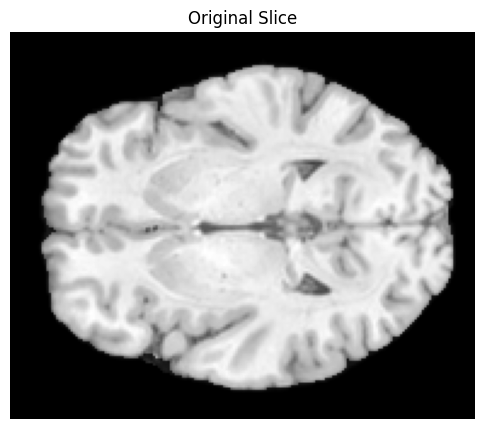

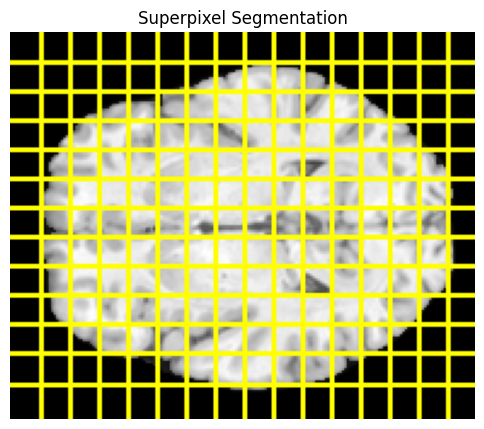

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# Your preprocessing code
sub_test = next(iter(val_loader))
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
image_array = sub_test['vol']['data'].to(device)
image_array[image_array < 0.01] = 0
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2

# Convert the PyTorch tensor to a NumPy array and select the middle slice
image_slice = image_array[0, 0, :, :, middle_slice_idx].cpu().numpy()
image_slice = image_slice/image_slice.max()

# Visualize the original slice
plt.figure(figsize=(6, 6))
plt.imshow(image_slice, cmap='gray')
plt.title("Original Slice")
plt.axis('off')
plt.show()

# Adjusted segmentation parameters
n_segments = 200
compactness = 30
sigma = 3  # Adjusting sigma for pre-smoothing

# Apply SLIC
segments = slic(image_slice, n_segments=n_segments, compactness=compactness, sigma=sigma, channel_axis=None)

# Plotting the superpixels
plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(image_slice, segments))
plt.title("Superpixel Segmentation")
plt.axis('off')
plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, measure, morphology
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage as ndi

# Assuming 'image_slice' is your 2D image slice from the 3D volume

# Equalize the image for better contrast
image_eq = exposure.equalize_hist(image_slice)

# Edge detection
edges = sobel(image_eq)

# Identify markers (local minima of the distance to the background)
distance = ndi.distance_transform_edt(image_eq)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image_eq)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

# Apply watershed to the markers and edges
labels = watershed(edges, markers, mask=image_eq)

# Show the output
plt.figure(figsize=(8, 8))
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')
plt.show()


NameError: name 'peak_local_max' is not defined

In [ ]:
mask =1- (sub_test['seg']['data']>0).float().to(device)
masked_image = images * mask

noise = torch.randn_like(images)
inpainted_image = inpaint_image(masked_image, mask, noise, model, scheduler, device)

In [ ]:
sample_time = 500
i = 0
all_errors = []

all_mse = []
all_ssim_values=[]
model.eval()
test_loader_iter = iter(test_loader)

progress_bar = tqdm.tqdm(enumerate(test_loader), total=len(test_loader), ncols=70)
for step, batch in progress_bar:
    images = batch['vol']['data'].to(device)
    images[images<0]=0
    # Expand the dimensions of batch['peak'] to make it [1, 1, 1, 1, 4]
    peak_expanded = (batch['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
    peak_expanded = peak_expanded.to(device)

    # Perform the division
    images = (images / peak_expanded)
    data_range = images.max()
    ssim_loss = MaskedLoss(SSIMLoss,spatial_dims=3, data_range=data_range)
    middle_slice_idx = images.size(-1) // 2  # Define middle_slice_idx here



    center = [dim // 2 for dim in images.shape[2:]]  # Calculate center indices
    cube_size = 20  # Half-size of the cube
    mask =1- (batch['seg']['data']>0).float().to(device)
    masked_image = images * mask

    noise = torch.randn_like(images)
    inpainted_image = inpaint_image(masked_image, mask, noise, model, scheduler, device)
    
    ssim_val =1- ssim_loss(images, inpainted_image,1-mask)
    mse_val = mse_loss(inpainted_image,images)
    all_ssim_values.append(ssim_val.item())
    all_mse.append(mse_val.item())
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].imshow(images[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
    axes[0, 0].set_title('Original Image')

    axes[0, 1].imshow(masked_image[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
    axes[0, 1].set_title('Noisy Image')
    
    axes[1, 0].imshow(inpainted_image[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
    axes[1, 0].set_title('Denoised Image')

    error = torch.abs(images - inpainted_image)
    axes[1, 1].imshow(error[i][0][:,:,middle_slice_idx].squeeze().cpu().numpy(), vmin=0, vmax=2, cmap='gray')
    axes[1, 1].set_title('Error Image')
    
    plt.tight_layout()
    plt.show()

    wandb.log({"sample_image_val": [wandb.Image(plt)]})
    plt.close()  # Close the figure to free up memory

# Average Dice score
avg_dice_score = sum(all_mse) / len(all_mse)
print(f"Average mse over the test set: {avg_dice_score}")

# Average SSIM values
avg_ssim_value = sum(all_ssim_values) / len(all_ssim_values)
print(f"Average SSIM between specified regions of original and denoised images: {avg_ssim_value}")



# # %%

# from monai.losses import MaskedLoss
# from monai.losses import MaskedDiceLoss
# # ssim_loss = MaskedLoss(SSIMLoss,spatial_dims=3)
# dice_loss = MaskedDiceLoss()
# ssim_loss = MaskedLoss(SSIMLoss,spatial_dims=3, data_range=1)